In [1]:
import os
import pickle

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

import seaborn as sns
from scipy.stats import kendalltau

from src.ipm import NeuronReader, grablabels

In [3]:
with open(os.path.join(r"G:\Codes\Processing\out\rsa", "gtruth.pkl"), 'rb') as handle:
    gtruth = pickle.load(handle)

In [6]:
def hist_equalize(matrix):
    matrix = np.copy(matrix)
    shape = matrix.shape
    matrix = matrix.reshape(-1)
    index = matrix.argsort()
    values = np.linspace(0, 1, index.shape[0])
    matrix[index] = values
    return matrix.reshape(shape)

def mkrdm(data):
    rdmat = 1 - cosine_similarity(data)
    return rdmat

def mkherdm(data):
    rdmat = 1 - cosine_similarity(data)
    return hist_equalize(rdmat)

In [20]:
def pltrdm(rdmat, labels, time, outName):
    x = np.arange(len(labels));
    d = (x[1] - x[0]) / 2
    extent = [x[0]-d, x[-1]+d, x[-1]+d, x[0]-d]
    plt.figure(figsize=(30, 30), dpi=50)
    plt.imshow(rdmat, extent=extent)
    plt.title(f'time: {time}', fontsize=50)
    plt.gca().set_xticks(range(len(labels)))
    plt.gca().set_yticks(range(len(labels)))
    plt.gca().set_xticklabels(labels)
    plt.gca().set_yticklabels(labels)
    plt.savefig(outName)
    plt.close()

# Single Monkey

In [4]:
selectivity = "fast"
monkey = "jenab"
data = NeuronReader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

In [10]:
out_path = f"G:/Codes/Processing/out/rsa/{monkey.capitalize()}-{selectivity.capitalize()}"

In [15]:
region = "pfc"
X = data.it if region=='it' else data.pfc
y = grablabels(hierarchy='categories')

img_index = np.arange(1, y.size+1)[np.argwhere(~np.isnan(y)).squeeze()]
X = X[np.argwhere(~np.isnan(y)).squeeze()]
y = y[np.argwhere(~np.isnan(y)).squeeze()]

yc = np.full(y.size, 'xx')
yc[y==0] = 'af'
yc[y==1] = 'hf'
yc[y==2] = 'mf'
yc[y==3] = 'hb'
yc[y==4] = 'mb'
yc[y==5] = 'ab'
yc[y==6] = 'xn'
yc[y==7] = 'xa'

argsort = np.argsort(y)
rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])
herdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

for itime in range(X.shape[2]):
    rdmat[:,:,itime] = mkrdm(X[argsort, :, itime])
    herdmat[:,:,itime] = mkherdm(X[argsort, :, itime])

In [16]:
lbl = np.array([yc[argsort][x] + '-' + str(img_index[argsort][x]) for x in range(len(argsort))])

In [17]:
for itime in np.arange(0, data.time.size, 5):
    pltrdm(herdmat[:,:,itime], lbl, data.time[itime], os.path.join(out_path, 'rdm', region.upper(), f'rdm-{int(itime)}.png'))

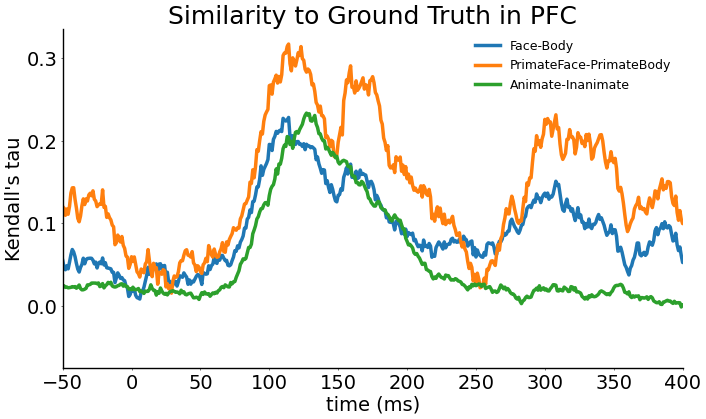

In [19]:
fontsize = 28
titlefontsize = 36

plt.figure(figsize=(16, 9), dpi=50)
for o in ['f-b', 'pf-pb', 'a-i']:
    tau = []
    ind = np.argwhere(~np.isnan(np.diag(gtruth[o]))).squeeze()
    gt = gtruth[o][ind][:, ind]
    rdm = rdmat[ind][:, ind]
    for itime in range(rdmat.shape[2]):
        t, _ = kendalltau(rdm[:,:,itime], gt)
        tau.append(t)
    plt.plot(data.time, tau, lw=5)

sns.despine()
plt.xlim(-50, 400)
plt.legend(["Face-Body", "PrimateFace-PrimateBody", "Animate-Inanimate"], fontsize=18, frameon=False)
plt.title(f'Similarity to Ground Truth in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel('Kendall\'s tau', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(plt.gca().spines.values(), linewidth=2)

plt.savefig(os.path.join(out_path, f'rsa-{region.lower()}'), dpi=600)

# Both Monkeys

In [21]:
nmb_component = .95
nmb_rep = 200

selectivity = "fast"

monkey = "jenab"
data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
data1 = NeuronReader(data_path)

monkey = "zebel"
data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
data2 = NeuronReader(data_path)

monkey = 'both'
out_path = f"G:/Codes/Processing/out/rsa/{monkey.capitalize()}-{selectivity.capitalize()}"

data = data1
data.it  = np.concatenate([data1.it, data2.it],   axis=1)
data.pfc = np.concatenate([data1.pfc, data2.pfc], axis=1)

In [29]:
region = "pfc"
X = data.it if region=='it' else data.pfc
y = grablabels(hierarchy='categories')

img_index = np.arange(1, y.size+1)[np.argwhere(~np.isnan(y)).squeeze()]
X = X[np.argwhere(~np.isnan(y)).squeeze()]
y = y[np.argwhere(~np.isnan(y)).squeeze()]

yc = np.full(y.size, 'xx')
yc[y==0] = 'af'
yc[y==1] = 'hf'
yc[y==2] = 'mf'
yc[y==3] = 'hb'
yc[y==4] = 'mb'
yc[y==5] = 'ab'
yc[y==6] = 'xn'
yc[y==7] = 'xa'

argsort = np.argsort(y)
rdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])
herdmat = np.nan * np.ones([argsort.size, argsort.size, X.shape[2]])

for itime in range(X.shape[2]):
    rdmat[:,:,itime] = mkrdm(X[argsort, :, itime])
    herdmat[:,:,itime] = mkherdm(X[argsort, :, itime])

In [30]:
lbl = np.array([yc[argsort][x] + '-' + str(img_index[argsort][x]) for x in range(len(argsort))])

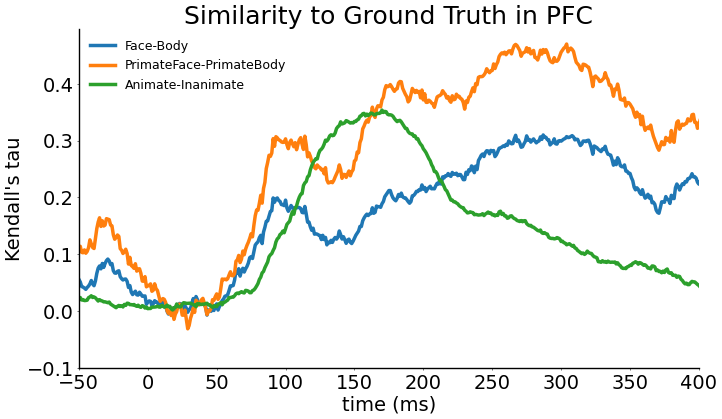

In [31]:
fontsize = 28
titlefontsize = 36

plt.figure(figsize=(16, 9), dpi=50)
for o in ['f-b', 'pf-pb', 'a-i']:
    tau = []
    ind = np.argwhere(~np.isnan(np.diag(gtruth[o]))).squeeze()
    gt = gtruth[o][ind][:, ind]
    rdm = rdmat[ind][:, ind]
    for itime in range(rdmat.shape[2]):
        t, _ = kendalltau(rdm[:,:,itime], gt)
        tau.append(t)
    plt.plot(data.time, tau, lw=5)

sns.despine()
plt.xlim(-50, 400)
plt.legend(["Face-Body", "PrimateFace-PrimateBody", "Animate-Inanimate"], fontsize=18, frameon=False)
plt.title(f'Similarity to Ground Truth in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel('Kendall\'s tau', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(plt.gca().spines.values(), linewidth=2)

plt.savefig(os.path.join(out_path, f'rsa-{region.lower()}'), dpi=600)